In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
from numpy.lib.stride_tricks import sliding_window_view

import matplotlib.pyplot as plt
import japanize_matplotlib

import joblib
import contextlib

from tqdm.auto import tqdm

from PIL import Image

import exercise_util

In [2]:
# 前回ダウンロードした約定履歴を使う
datadir = 'data/binance'
symbol = 'BTCUSDT'

# 約定プロファイルを作成するときの価格方向の解像度。最低価格0.1USDTから最大価格1M USDTまで、logspaceでこの数だけ分割する
num_columns = 4096

# 価格を分割したbinの境界値
bin_edges = [_ for _ in np.logspace(np.log10(0.1), np.log10(1_000_000.0), num_columns)]

In [3]:
# 一日分の約定履歴ファイルを入力として、その一日にbin_edgesの境界値で分割された価格の範囲で
# それぞれ何USDTの約定があったかをnumpyの配列として返す関数
def calc_digitized_quote_qty(idx, filename, num_cols, bin_edges):
    _image_row_nparray = np.zeros(num_cols)

    _df = pd.read_pickle(filename)
    _df['digitized_label'] = np.digitize(_df['price'], bin_edges)
    df_active_bins = _df.groupby('digitized_label')['quote_qty'].sum() / _df['quote_qty'].sum()

    for _idx in df_active_bins.index:
        _image_row_nparray[_idx - 1] = df_active_bins[_idx]
    
    return (idx, _image_row_nparray)

In [4]:
# 全コア数-2個のコアで並列処理を行い、価格ファイルを処理して約定プロファイルを作成する関数
def generate_trades_profile_image(datadir, symbol):
    # データファイルの一覧を取得し、生成する約定プロファイルの時間方向の解像度を決定する
    list_filenames = exercise_util.identify_available_datafile(datadir, 'trades', symbol)
    num_rows = len(list_filenames)
    
    with exercise_util.tqdm_joblib(total = num_rows):
        results = joblib.Parallel(n_jobs = -2, timeout = 60*60*24)([joblib.delayed(calc_digitized_quote_qty)(_idx, _filename, num_columns, bin_edges) for _idx, _filename in enumerate(list_filenames)])
    
    # numpyの行列として約定プロファイルを作成する、各要素の値は、その日にその価格帯で約定した取引のUSDT建てボリューム
    image_nparray = np.zeros(num_rows * num_columns).reshape(num_rows, num_columns)
    for _result in results:
        image_nparray[_result[0]] = _result[1]
    
    return image_nparray

In [5]:
# プロファイルをnumpy行列 (グレイスケール画像) として求める
image_nparray = generate_trades_profile_image(datadir, symbol)

  0%|          | 0/1144 [00:00<?, ?it/s]

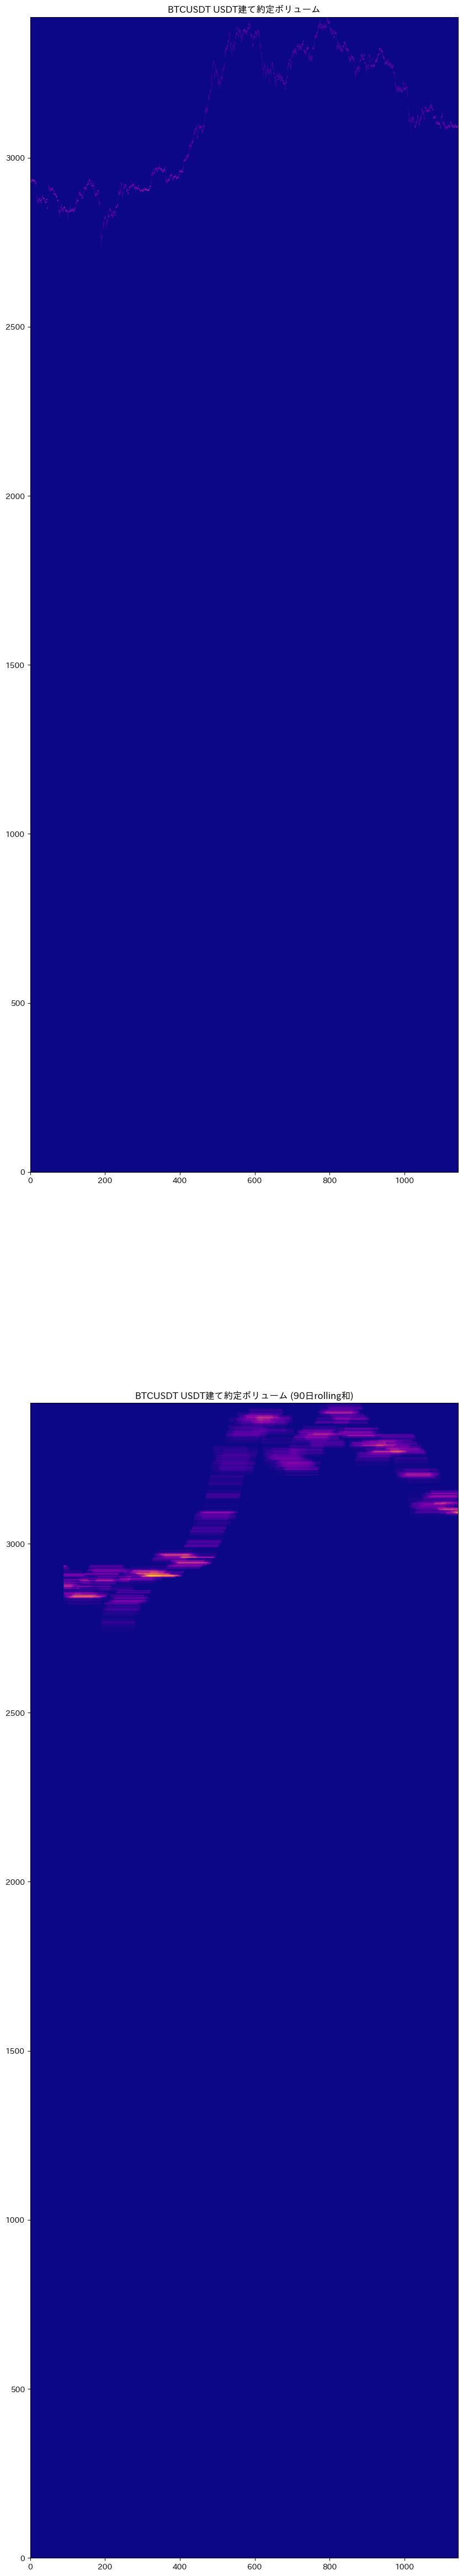

In [15]:
# 直近30日分を描画することにして、行列全体から30行 x num_columns列を抜き出す
time_render_range = (0, image_nparray.shape[0] - 1)

# 14日分のローリングウィンドウを使って約定ボリュームの14日分の和を価格帯ごとに求める
window_size = 90
image_sliding_window_nparray = sliding_window_view(image_nparray, window_size, axis = 0).sum(axis = 2)

# ローリングウィンドウを使った分、行数が少なくなるので0初期化された行を追加してから描画領域を切り出す
pad_nparray = np.zeros((window_size - 1) * image_nparray.shape[1]).reshape(window_size - 1, image_nparray.shape[1])
image_sliding_window_nparray = np.vstack((pad_nparray, image_sliding_window_nparray))
image_sliding_window_nparray_render = image_sliding_window_nparray[time_render_range[0]:time_render_range[1], :]

# 描画範囲のなかで、取引ボリュームが0でない最大の価格帯と最低の価格帯を取得する
# (bin_edgesの境界値で分割された価格範囲のインデックスの最大値と最小値を取得している)
masked_nparray = ma.masked_where(image_sliding_window_nparray_render == 0, image_sliding_window_nparray_render)
price_argmin_nonzero = np.argmin(masked_nparray, axis = 1)
price_argmax_nonzero = np.argmax(masked_nparray, axis = 1)
price_argminmax_nonzero = np.concatenate([price_argmin_nonzero, price_argmax_nonzero])
price_render_range = (min(price_argminmax_nonzero), max(price_argminmax_nonzero))

# 描画時の画像の縦横比を求め、その縦横比に基づいてFigureを作成する
y_proportion = (price_render_range[1] - price_render_range[0]) / (time_render_range[1] - time_render_range[0])
fig, axs = plt.subplots(2, 1, figsize=(10, y_proportion * 10 * 2))

# image_nparrayは行 (インデックスが増えると時間が進む) が時間方向
# 列 (インデックスが増えると価格帯が対数スケールで上がる) が価格帯インデックス方向
axs[0].imshow(np.rot90(image_nparray), origin = 'upper', extent = [0, image_nparray.shape[0], 0, image_nparray.shape[1]], interpolation = None, cmap = 'plasma')
axs[0].set_xlim(time_render_range[0], time_render_range[1])
axs[0].set_ylim(price_render_range[0], price_render_range[1])
axs[0].set_title('BTCUSDT USDT建て約定ボリューム')
axs[0].set_aspect('auto')

# image_nparrayは行 (インデックスが増えると時間が進む) が時間方向
# 列 (インデックスが増えると価格帯が対数スケールで上がる) が価格帯インデックス方向で、描画時にわかりにくいので左に90度回転する
axs[1].imshow(np.rot90(image_sliding_window_nparray), extent = [0, image_sliding_window_nparray.shape[0], 0, image_sliding_window_nparray.shape[1]], interpolation = None, cmap = 'plasma')
axs[1].set_xlim(time_render_range[0], time_render_range[1])
axs[1].set_ylim(price_render_range[0], price_render_range[1])
axs[1].set_title(f'BTCUSDT USDT建て約定ボリューム ({window_size}日rolling和)')
axs[1].set_aspect('auto')

fig.show()